In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt
import itertools

# Hyperparameters
LR = 1e-4
EPOCHS = 100
BATCH_SIZE = 32
IMG_SHAPE = (224, 224, 3)
InputPath = "/Users/kavyasreechowdary/Documents/ML Project/FaceMask_Dataset"
Classes = ["WithMask", "WithoutMask"]


2025-04-23 15:16:23.264117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load and preprocess images
imagePaths = []
for className in Classes:
    classPath = os.path.join(InputPath, className)
    for filename in os.listdir(classPath):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            imagePaths.append(os.path.join(classPath, filename))

images, labels = [], []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    images.append(image)
    labels.append(label)

# Encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Convert to numpy arrays
images = np.array(images, dtype="float32")
labels = np.array(labels)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.20, stratify=labels, random_state=42)


In [5]:
# Data augmentation
data_augmentation = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, 
                                       height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, 
                                       fill_mode="nearest")

# Load base model (MobileNetV2)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)

# Build the model
head = base_model.output
head = GlobalAveragePooling2D()(head)
head = Flatten(name="flatten")(head)
head = Dense(128, activation="relu")(head)
head = Dropout(0.5)(head)
head = Dense(2, activation="softmax")(head)
model = Model(inputs=base_model.input, outputs=head)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()


/opt/anaconda3/envs/face_env/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Train the model with data augmentation
history = model.fit(data_augmentation.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, Y_test),
                    validation_steps=len(X_test) // BATCH_SIZE, epochs=EPOCHS)


/opt/anaconda3/envs/face_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 886ms/step - accuracy: 0.6422 - loss: 0.7001 - val_accuracy: 0.8775 - val_loss: 0.4093
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 801ms/step - accuracy: 0.7721 - loss: 0.5161 - val_accuracy: 0.8750 - val_loss: 0.3496
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 842ms/step - accuracy: 0.8187 - loss: 0.4482 - val_accuracy: 0.8825 - val_loss: 0.3342
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 853ms/step - accuracy: 0.8332 - loss: 0.4402 - val_accuracy: 0.8725 - val_loss: 0.3373
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 855ms/step - accuracy: 0.8305 - loss: 0.4157 - val_accuracy: 0.8800 - val_loss: 0.3254
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 820ms/step - accuracy: 0.8485 - loss: 0.4022 - val_accuracy: 0.8775 - val_loss: 0.3149
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 817ms/step - accuracy: 0.8657 - loss: 0.3829 - val_accuracy: 0.8800 - val_loss: 0.3112
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 835ms/step - accuracy: 0.8599 - loss: 0.3724 - 

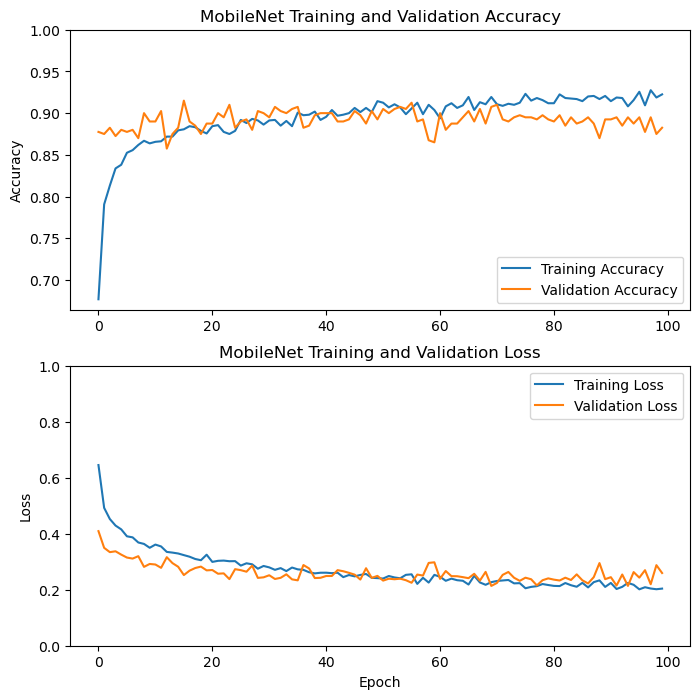

[INFO] Evaluating network...
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 652ms/step
              precision    recall  f1-score   support

    WithMask       0.83      0.96      0.89       200
 WithoutMask       0.96      0.80      0.87       200

    accuracy                           0.88       400
   macro avg       0.89      0.88      0.88       400
weighted avg       0.89      0.88      0.88       400



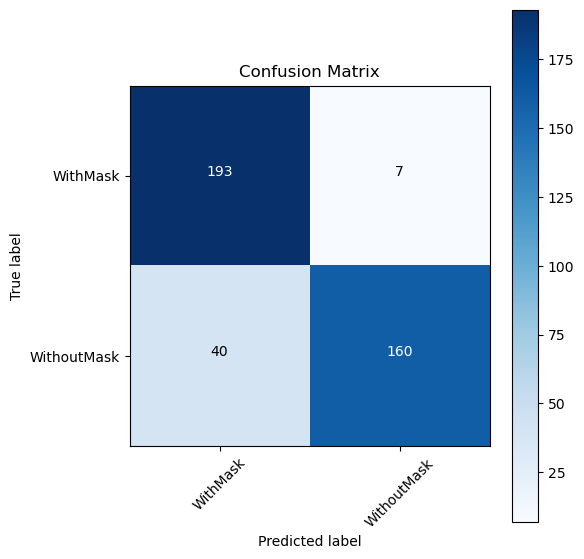

In [9]:
# Function to plot training history
def plot_train_history(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))

    # Accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title(f'{name} Training and Validation Accuracy')

    # Loss plot
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, 1.0])
    plt.title(f'{name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_train_history(history, 'MobileNet')

# Evaluate model performance
print("[INFO] Evaluating network...")
predIdxs = model.predict(X_test, batch_size=BATCH_SIZE)
predIdxs = np.argmax(predIdxs, axis=1)

# Classification report
print(classification_report(Y_test.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Confusion matrix
cm = confusion_matrix(Y_test.argmax(axis=1), predIdxs)
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(Classes))
plt.xticks(tick_marks, Classes, rotation=45)
plt.yticks(tick_marks, Classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


Sensitivity: 0.8
Specificity: 0.965
Accuracy: 0.8825


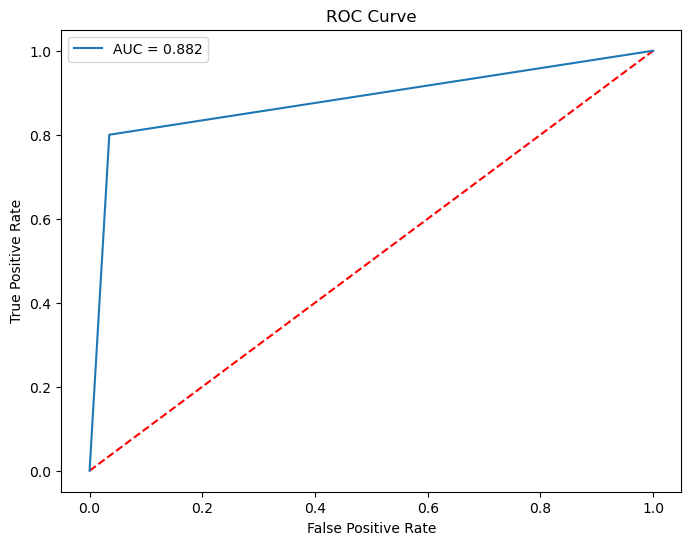

Model Saved!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,212 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [11]:
# Calculate sensitivity, specificity, and accuracy
def calculate_sensitivity_specificity(y_test, y_pred_test):
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    true_pos = (y_pred_test == 1) & actual_pos
    false_pos = (y_pred_test == 1) & actual_neg
    true_neg = (y_pred_test == 0) & actual_neg
    false_neg = (y_pred_test == 0) & actual_pos

    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    accuracy = np.mean(y_pred_test == y_test)
    
    return sensitivity, specificity, accuracy

sensitivity, specificity, accuracy = calculate_sensitivity_specificity(Y_test.argmax(axis=1), predIdxs)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('Accuracy:', accuracy)

# ROC Curve
roc_log = roc_auc_score(Y_test.argmax(axis=1), predIdxs)
false_positive_rate, true_positive_rate, _ = roc_curve(Y_test.argmax(axis=1), predIdxs)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Save and load model
model.save('MobileNet.h5')
#model.save('my_model.keras')
print('Model Saved!')

savedModel = tf.keras.models.load_model('MobileNet.h5')
savedModel.summary()


In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Example placeholders — replace these with your actual data variables
# X_train: training images (numpy array)
# y_train: training labels (categorical, one-hot encoded)
# You can also adjust the batch_size, epochs, and validation_split as needed

model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_split=0.2)


Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 762ms/step - accuracy: 0.9114 - loss: 0.2526 - val_accuracy: 0.9062 - val_loss: 0.2710
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 744ms/step - accuracy: 0.9143 - loss: 0.2249 - val_accuracy: 0.9250 - val_loss: 0.1591
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 795ms/step - accuracy: 0.9393 - loss: 0.1556 - val_accuracy: 0.9375 - val_loss: 0.1589
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 974ms/step - accuracy: 0.9263 - loss: 0.1887 - val_accuracy: 0.9281 - val_loss: 0.1611
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 891ms/step - accuracy: 0.9510 - loss: 0.1171 - val_accuracy: 0.9406 - val_loss: 0.1423


In [17]:
# Replace X_test and y_test with your test data
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy:.2f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 540ms/step - accuracy: 0.9174 - loss: 0.1762
Test Accuracy: 0.94
